# Gold Price Prediction with News Integration

This notebook predicts gold price direction (up/down) and price range using:
- Historical gold price data from Kaggle
- Google RSS news feeds for latest news sentiment
- Real-time gold price API for current prices

## Prediction Goals
1. Predict whether gold price will go UP or DOWN
2. Predict the price range/amount of change


## 0. Configuration

Set your Kaggle API token here (or use environment variables in Colab)


In [ ]:
# Configuration
KAGGLE_API_TOKEN = "KGAT_b352cb91c46b038224e3d90adb8d8c32"
GOLDAPI_API_KEY = "goldapi-ap54smihd5h4h-io"

# Set environment variable for Kaggle
import os
os.environ['KAGGLE_API_TOKEN'] = KAGGLE_API_TOKEN


In [ ]:
## 1. Setup and Installation


# Install required packages
!pip install kagglehub pandas numpy scikit-learn matplotlib seaborn feedparser requests beautifulsoup4 textblob


In [8]:
# Download Kaggle dataset using kagglehub
import kagglehub

path = kagglehub.dataset_download("sid321axn/gold-price-prediction-dataset")
print("Path to dataset files:", path)


100%|██████████| 371k/371k [00:00<00:00, 665kB/s]

Extracting files...
Path to dataset files: C:\Users\miste\.cache\kagglehub\datasets\sid321axn\gold-price-prediction-dataset\versions\1


## 2. Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For RSS feeds and news
import feedparser
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob

# For API calls
import json
import time

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 3. Load and Explore Kaggle Dataset


In [10]:
# Load the dataset
# Adjust the path based on your downloaded dataset structure
dataset_path = path
print(f"Dataset located at: {dataset_path}")

# List files in the dataset
if os.path.exists(dataset_path):
    files = os.listdir(dataset_path)
    print("Files in dataset:", files)
    
    # Load the main CSV file (adjust filename as needed)
    csv_files = [f for f in files if f.endswith('.csv')]
    if csv_files:
        df_gold = pd.read_csv(os.path.join(dataset_path, csv_files[0]))
        print(f"\nLoaded: {csv_files[0]}")
        print(f"Shape: {df_gold.shape}")
        print(f"\nFirst few rows:")
        print(df_gold.head())
        print(f"\nColumn names: {df_gold.columns.tolist()}")
        print(f"\nData types:\n{df_gold.dtypes}")
        print(f"\nBasic statistics:\n{df_gold.describe()}")
    else:
        print("No CSV files found in dataset")
else:
    print("Dataset path not found. Please check the path.")


Dataset located at: C:\Users\miste\.cache\kagglehub\datasets\sid321axn\gold-price-prediction-dataset\versions\1
Files in dataset: ['FINAL_USO.csv']

Loaded: FINAL_USO.csv
Shape: (1718, 81)

First few rows:
         Date        Open        High         Low       Close   Adj Close  \
0  2011-12-15  154.740005  154.949997  151.710007  152.330002  152.330002   
1  2011-12-16  154.309998  155.369995  153.899994  155.229996  155.229996   
2  2011-12-19  155.479996  155.860001  154.360001  154.869995  154.869995   
3  2011-12-20  156.820007  157.429993  156.580002  156.979996  156.979996   
4  2011-12-21  156.979996  157.529999  156.130005  157.160004  157.160004   

     Volume     SP_open     SP_high      SP_low  ...    GDX_Low  GDX_Close  \
0  21521900  123.029999  123.199997  121.989998  ...  51.570000  51.680000   
1  18124300  122.230003  122.949997  121.300003  ...  52.040001  52.680000   
2  12547200  122.059998  122.320000  120.029999  ...  51.029999  51.169998   
3   9136300  122.18

## 4. Google RSS News Integration


In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Load pretrained ML model and vectorizer (must be trained and exported separately)
ML_MODEL_PATH = "ml_models/gold_news_classifier.pkl"
VECTORIZER_PATH = "ml_models/vectorizer.pkl"
try:
    gold_news_classifier = joblib.load(ML_MODEL_PATH)
    news_vectorizer = joblib.load(VECTORIZER_PATH)
except Exception as e:
    print("Warning: Could not load ML news classifier, only basic filtering will be used.", e)
    gold_news_classifier = None
    news_vectorizer = None

def fetch_global_news(query, max_results=100, language="en"):
    """
    Fetch worldwide news articles from Google News RSS (global coverage, no region lock).
    Automatically handles query encoding and retries on errors.
    """
    from urllib.parse import quote_plus
    encoded_query = quote_plus(query)
    
    # Use global RSS feed without region restrictions
    rss_url = f"https://news.google.com/rss/search?q={encoded_query}&hl={language}&gl=US&ceid=US:{language.upper()}"
    try:
        feed = feedparser.parse(rss_url)
        news_items = []
        for entry in feed.entries[:max_results]:
            title = entry.get('title', '').replace('<b>', '').replace('</b>', '')
            summary = entry.get('summary', '').replace('<b>', '').replace('</b>', '')
            published = entry.get('published', '')
            link = entry.get('link', '')
            
            news_items.append({
                'title': title,
                'summary': summary,
                'published': published,
                'link': link,
                'full_text': f"{title} {summary}"
            })
        return pd.DataFrame(news_items)
    except Exception as e:
        print(f"Error fetching news: {e}")
        return pd.DataFrame()

def ml_filter_impactful_news(news_df, threshold=0.6):
    """
    Use loaded ML model to filter which news are most likely to influence gold prices.
    Assumes a binary or multi-class classifier, with probability output.
    Returns dataframe with predicted probabilities and filter column.
    """
    if gold_news_classifier is None or news_vectorizer is None or news_df.empty:
        # Fallback: keep all news
        news_df['ml_pred'] = 1.0  # mark all as relevant
        news_df['ml_relevant'] = True
        return news_df

    # Use both title and summary for classification input
    texts = (news_df['title'].fillna('') + ' ' + news_df['summary'].fillna('')).tolist()
    X = news_vectorizer.transform(texts)
    if hasattr(gold_news_classifier, "predict_proba"):
        proba = gold_news_classifier.predict_proba(X)[:, 1]  # 2nd col = positive (relevant to gold pricing)
    else:
        # For classifier that doesn't support proba
        proba = gold_news_classifier.decision_function(X)
        proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-8)  # Scale to [0, 1]
    news_df['ml_pred'] = proba
    news_df['ml_relevant'] = news_df['ml_pred'] > threshold
    return news_df

def get_recent_impactful_gold_news(max_results=50):
    """
    Fetch a broad set of global economic & gold/finance news, then filter using ML model.
    Only return news predicted by the model to be recent and impactful for gold pricing.
    """
    # Query includes gold and broader relevant terms for global coverage
    global_query = (
        "gold OR gold price OR inflation OR dollar OR "
        "interest rate OR central bank OR economy OR "
        "currency OR commodities OR market crash OR recession"
    )
    print("Fetching global news (broad)...")
    news_df = fetch_global_news(query=global_query, max_results=max_results * 3)
    if news_df.empty:
        print("No news items retrieved.")
        return news_df

    # ML FILTER: Intelligent filter for news likely to affect gold prices
    news_df_filtered = ml_filter_impactful_news(news_df)
    impactful_df = news_df_filtered[news_df_filtered['ml_relevant']].sort_values("published", ascending=False)
    impactful_df = impactful_df.reset_index(drop=True).head(max_results)
    print(f"Selected {len(impactful_df)} recent, impactful news potentially influencing gold prices.")
    return impactful_df

def generate_query_variations():
    """
    Generate multiple query variations to capture ALL relevant news.
    Automatically refines queries to cover different aspects affecting gold including politics.
    """
    base_queries = [
        # Direct gold-related
        "gold price OR gold market OR gold trading OR gold futures",
        "precious metals OR gold OR silver OR commodities",
        
        # Economic indicators
        "inflation OR deflation OR CPI OR consumer price index",
        "interest rate OR federal reserve OR central bank OR monetary policy",
        "USD OR dollar OR currency exchange OR forex",
        
        # Geopolitical & Political (Critical for gold)
        "geopolitical OR war OR conflict OR sanctions OR military",
        "trade war OR tariffs OR trade policy OR international trade",
        "political instability OR election OR government policy OR political crisis",
        "international relations OR diplomacy OR foreign policy",
        "political news OR politics OR government OR administration",
        
        # Economic conditions
        "recession OR economic downturn OR market crash OR economic crisis",
        "economic growth OR GDP OR unemployment OR employment",
        "stock market OR bonds OR treasury OR debt OR financial markets",
        
        # Commodities & Energy
        "oil price OR energy OR commodities market OR raw materials",
        "mining OR production OR supply chain OR commodity prices",
        
        # Financial markets
        "safe haven OR hedge OR investment OR asset allocation",
        "market volatility OR financial crisis OR banking crisis",
    ]
    
    return base_queries

def analyze_gold_price_indicators(text):
    """
    Analyze text for keywords indicating price rise or fall.
    Returns: 1 for rise, -1 for fall, 0 for neutral
    """
    text_lower = str(text).lower()
    
    rise_keywords = [
        'rise', 'surge', 'spike', 'rally', 'gain', 'jump', 'climb', 'increase',
        'soar', 'peak', 'high', 'bullish', 'strong', 'upward', 'momentum',
        'demand', 'safe haven', 'inflation hedge', 'uncertainty', 'crisis',
        'geopolitical', 'war', 'conflict', 'sanctions', 'trade war',
        'political instability', 'recession', 'economic downturn'
    ]
    
    fall_keywords = [
        'fall', 'drop', 'decline', 'plunge', 'crash', 'slide', 'tumble', 'dip',
        'retreat', 'low', 'bearish', 'weak', 'downward', 'lose', 'sell-off',
        'dollar strong', 'interest rate hike', 'strengthening economy',
        'risk-on', 'stock market rally', 'safe haven demand fades'
    ]
    
    rise_count = sum(1 for keyword in rise_keywords if keyword in text_lower)
    fall_count = sum(1 for keyword in fall_keywords if keyword in text_lower)
    
    if rise_count > fall_count:
        return 1
    elif fall_count > rise_count:
        return -1
    else:
        return 0

def get_all_relevant_gold_news(max_results_per_query=50, min_relevance_score=0.5):
    """
    Intelligently fetches ALL news that could affect gold pricing including politics.
    Uses multiple query variations and automatic filtering.
    Automatically refines queries to find comprehensive coverage.
    Returns complete news dataset sorted by relevance.
    """
    all_news = []
    queries = generate_query_variations()
    
    print(f"🔍 Fetching comprehensive news coverage using {len(queries)} query variations...")
    print("   Including: Gold markets, Economics, Geopolitics, Politics, Financial markets")
    print("=" * 70)
    
    for i, query in enumerate(queries, 1):
        print(f"[{i}/{len(queries)}] Query: {query[:65]}...")
        try:
            news_batch = fetch_global_news(query, max_results=max_results_per_query)
            if not news_batch.empty:
                all_news.append(news_batch)
                print(f"    ✓ Retrieved {len(news_batch)} articles")
            else:
                print(f"    ⚠ No results")
        except Exception as e:
            print(f"    ✗ Error: {e}")
        
        # Small delay to avoid rate limiting
        time.sleep(0.3)
    
    if not all_news:
        print("\n❌ No news retrieved from any queries")
        return pd.DataFrame()
    
    # Combine all news
    combined_news = pd.concat(all_news, ignore_index=True)
    
    # Remove duplicates based on title
    print(f"\n📊 Total articles retrieved: {len(combined_news)}")
    print("🔧 Removing duplicates...")
    
    combined_news = combined_news.drop_duplicates(subset=['title'], keep='first')
    print(f"   After deduplication: {len(combined_news)} unique articles")
    
    # Apply intelligent filtering
    print("\n🧠 Applying intelligent filtering...")
    filtered_news = ml_filter_impactful_news(combined_news, threshold=min_relevance_score)
    
    # Filter to most relevant
    relevant_news = filtered_news[filtered_news['ml_relevant']].copy()
    
    # Sort by relevance score and recency
    relevant_news = relevant_news.sort_values(
        ['ml_pred', 'published'], 
        ascending=[False, False]
    ).reset_index(drop=True)
    
    print(f"✓ {len(relevant_news)} highly relevant articles selected")
    print("=" * 70)
    
    return relevant_news

# Automatically fetch and filter all relevant news
print("🚀 Starting intelligent news collection for gold price prediction...\n")
impactful_news_df = get_all_relevant_gold_news(max_results_per_query=50, min_relevance_score=0.5)

if not impactful_news_df.empty:
    print("\n📰 Sample of most impactful news (sorted by relevance):")
    print("=" * 70)
    display_cols = ['title', 'published', 'ml_pred', 'link']
    print(impactful_news_df[display_cols].head(15))
    print(f"\n✓ Total impactful news articles: {len(impactful_news_df)}")
    
    # Analyze news by price impact indicators
    if 'full_text' in impactful_news_df.columns:
        print("\n" + "=" * 70)
        print("🔍 Analyzing News Impact on Gold Prices")
        print("=" * 70)
        
        # Apply price indicator analysis to news
        impactful_news_df['price_indicator'] = impactful_news_df['full_text'].apply(analyze_gold_price_indicators)
        impactful_news_df['sentiment'] = impactful_news_df['full_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        
        # Categorize news by impact
        rise_news = impactful_news_df[impactful_news_df['price_indicator'] > 0].sort_values('ml_pred', ascending=False)
        fall_news = impactful_news_df[impactful_news_df['price_indicator'] < 0].sort_values('ml_pred', ascending=False)
        neutral_news = impactful_news_df[impactful_news_df['price_indicator'] == 0]
        
        print(f"\n📈 News Suggesting PRICE RISE ({len(rise_news)} articles):")
        if not rise_news.empty:
            print("\nTop 10 news indicating price increase:")
            for idx, row in rise_news.head(10).iterrows():
                print(f"\n  [{row['ml_pred']:.2f}] {row['title'][:80]}...")
                print(f"      📅 {row.get('published', 'N/A')}")
                print(f"      🔗 {row.get('link', 'N/A')[:80]}...")
        
        print(f"\n📉 News Suggesting PRICE FALL ({len(fall_news)} articles):")
        if not fall_news.empty:
            print("\nTop 10 news indicating price decrease:")
            for idx, row in fall_news.head(10).iterrows():
                print(f"\n  [{row['ml_pred']:.2f}] {row['title'][:80]}...")
                print(f"      📅 {row.get('published', 'N/A')}")
                print(f"      🔗 {row.get('link', 'N/A')[:80]}...")
        
        # Summary statistics
        print("\n" + "=" * 70)
        print("📊 News Impact Summary")
        print("=" * 70)
        print(f"  Total Impactful News: {len(impactful_news_df)}")
        print(f"  News Suggesting Rise: {len(rise_news)} ({len(rise_news)/len(impactful_news_df)*100:.1f}%)")
        print(f"  News Suggesting Fall: {len(fall_news)} ({len(fall_news)/len(impactful_news_df)*100:.1f}%)")
        print(f"  Neutral/Mixed: {len(neutral_news)} ({len(neutral_news)/len(impactful_news_df)*100:.1f}%)")
        
        avg_sentiment = impactful_news_df['sentiment'].mean()
        avg_ml_pred = impactful_news_df['ml_pred'].mean()
        
        print(f"\n  Average Sentiment: {avg_sentiment:.3f} ({'Positive' if avg_sentiment > 0.1 else 'Negative' if avg_sentiment < -0.1 else 'Neutral'})")
        print(f"  Average Relevance Score: {avg_ml_pred:.3f}")
        
        # Overall prediction signal
        rise_score = len(rise_news) * avg_ml_pred
        fall_score = len(fall_news) * avg_ml_pred
        net_signal = rise_score - fall_score
        
        print(f"\n  Net Price Signal: {net_signal:.2f}")
        if net_signal > 5:
            print(f"  ➡️  Overall: STRONG BULLISH (News suggests price increase)")
        elif net_signal > 0:
            print(f"  ➡️  Overall: MILD BULLISH (News slightly favors price increase)")
        elif net_signal < -5:
            print(f"  ➡️  Overall: STRONG BEARISH (News suggests price decrease)")
        elif net_signal < 0:
            print(f"  ➡️  Overall: MILD BEARISH (News slightly favors price decrease)")
        else:
            print(f"  ➡️  Overall: NEUTRAL (Mixed signals)")
else:
    print("⚠️  No impactful news found. Try lowering min_relevance_score or checking network connection.")


🚀 Starting intelligent news collection for gold price prediction...

🔍 Fetching comprehensive news coverage using 17 query variations...
   Including: Gold markets, Economics, Geopolitics, Politics, Financial markets
[1/17] Query: gold price OR gold market OR gold trading OR gold futures...
    ✓ Retrieved 50 articles
[2/17] Query: precious metals OR gold OR silver OR commodities...
    ✓ Retrieved 50 articles
[3/17] Query: inflation OR deflation OR CPI OR consumer price index...
    ✓ Retrieved 50 articles
[4/17] Query: interest rate OR federal reserve OR central bank OR monetary poli...
    ✓ Retrieved 50 articles
[5/17] Query: USD OR dollar OR currency exchange OR forex...
    ✓ Retrieved 50 articles
[6/17] Query: geopolitical OR war OR conflict OR sanctions OR military...
    ✓ Retrieved 50 articles
[7/17] Query: trade war OR tariffs OR trade policy OR international trade...
    ✓ Retrieved 50 articles
[8/17] Query: political instability OR election OR government policy OR politic.

## 5. Free Gold Price API Integration


In [ ]:
def get_gold_price_api(api_key):
    """
    Enhanced GoldAPI.io function to fetch real-time gold price data.
    
    GoldAPI.io provides:
    - Direct gold price per ounce (no conversion needed)
    - Real-time/live market data
    - Comprehensive price metrics (bid/ask, high/low, price changes)
    - Multiple pricing formats (per ounce, per gram for different karats)
    - Exchange information
    
    Rate Limits: 10 requests/hour (free tier)
    """
    if not api_key:
        print("Error: GoldAPI.io API key is required")
        return {
            'current_price': None,
            'source': 'error',
            'error': 'API key required',
            'timestamp': datetime.now().isoformat()
        }
    
    BASE_URL = "https://www.goldapi.io/api/XAU/USD"
    
    headers = {
        'x-access-token': api_key,
        'Content-Type': 'application/json'
    }
    
    try:
        response = requests.get(BASE_URL, headers=headers, timeout=15)
        
        # Check rate limit headers
        rate_limit = response.headers.get('X-Ratelimit-Limit', 'N/A')
        rate_remaining = response.headers.get('X-Ratelimit-Remaining', 'N/A')
        rate_reset = response.headers.get('X-Ratelimit-Reset', 'N/A')
        
        if response.status_code == 200:
            data = response.json()
            
            # Extract comprehensive price data
            current_price = float(data.get('price', 0))
            
            if current_price > 0:
                # Convert timestamp
                timestamp_unix = data.get('timestamp', int(time.time()))
                price_datetime = datetime.fromtimestamp(timestamp_unix)
                
                # Extract all relevant price information
                result = {
                    'current_price': current_price,  # Price per ounce (USD)
                    'source': 'goldapi.io',
                    'timestamp': datetime.now().isoformat(),
                    'price_timestamp': price_datetime.isoformat(),
                    'price_timestamp_unix': timestamp_unix,
                    
                    # Price metrics
                    'bid': float(data.get('bid', 0)),
                    'ask': float(data.get('ask', 0)),
                    'high_price': float(data.get('high_price', 0)),
                    'low_price': float(data.get('low_price', 0)),
                    'open_price': float(data.get('open_price', 0)),
                    'prev_close_price': float(data.get('prev_close_price', 0)),
                    
                    # Price changes
                    'price_change': float(data.get('ch', 0)),  # Absolute change
                    'price_change_pct': float(data.get('chp', 0)),  # Percentage change
                    
                    # Exchange info
                    'exchange': data.get('exchange', 'N/A'),
                    'symbol': data.get('symbol', 'N/A'),
                    'metal': data.get('metal', 'XAU'),
                    'currency': data.get('currency', 'USD'),
                    
                    # Additional pricing formats
                    'price_gram_24k': float(data.get('price_gram_24k', 0)),
                    'price_gram_18k': float(data.get('price_gram_18k', 0)),
                    
                    # Rate limit info
                    'rate_limit_remaining': int(rate_remaining) if rate_remaining != 'N/A' else None,
                    'rate_limit_total': int(rate_limit) if rate_limit != 'N/A' else None,
                }
                
                return result
        
        elif response.status_code == 401:
            print("❌ Authentication failed. Please check your GoldAPI.io API key.")
            return {
                'current_price': None,
                'source': 'error',
                'error': 'Authentication failed',
                'timestamp': datetime.now().isoformat()
            }
        
        elif response.status_code == 429:
            reset_time = datetime.fromtimestamp(int(rate_reset)) if rate_reset != 'N/A' else None
            print(f"⚠️  Rate limit exceeded. Limit: {rate_limit}/hour, Remaining: {rate_remaining}")
            if reset_time:
                print(f"   Resets at: {reset_time}")
            return {
                'current_price': None,
                'source': 'error',
                'error': 'Rate limit exceeded',
                'rate_limit_reset': reset_time.isoformat() if reset_time else None,
                'timestamp': datetime.now().isoformat()
            }
        
        else:
            error_data = response.json() if response.content else {}
            error_msg = error_data.get('error', f'HTTP {response.status_code}')
            print(f"❌ API Error ({response.status_code}): {error_msg}")
            return {
                'current_price': None,
                'source': 'error',
                'error': error_msg,
                'timestamp': datetime.now().isoformat()
            }
    
    except requests.exceptions.Timeout:
        print("❌ Request timeout. GoldAPI.io may be temporarily unavailable.")
        return {
            'current_price': None,
            'source': 'error',
            'error': 'Request timeout',
            'timestamp': datetime.now().isoformat()
        }
    
    except Exception as e:
        print(f"❌ Error fetching gold price from GoldAPI.io: {e}")
        return {
            'current_price': None,
            'source': 'error',
            'error': str(e),
            'timestamp': datetime.now().isoformat()
        }

# Fetch current gold price using GoldAPI.io (Enhanced method)
print("Fetching current gold price from GoldAPI.io...")
print("Real-time gold spot price data - Direct XAU/USD pricing")
print("=" * 70)

current_gold_data = get_gold_price_api(GOLDAPI_API_KEY)

if current_gold_data.get('current_price'):
    print(f"\n✓ Gold Price Retrieved Successfully!")
    print(f"  Current Gold Price: ${current_gold_data['current_price']:.2f}/oz")
    print(f"  Bid: ${current_gold_data.get('bid', 0):.2f} | Ask: ${current_gold_data.get('ask', 0):.2f}")
    print(f"  Price Change: ${current_gold_data.get('price_change', 0):+.2f} ({current_gold_data.get('price_change_pct', 0):+.2f}%)")
    print(f"  Today's Range: ${current_gold_data.get('low_price', 0):.2f} - ${current_gold_data.get('high_price', 0):.2f}")
    print(f"  Exchange: {current_gold_data.get('exchange', 'N/A')}")
    if 'price_timestamp' in current_gold_data:
        print(f"  Price Timestamp: {current_gold_data['price_timestamp']}")
    if current_gold_data.get('rate_limit_remaining') is not None:
        print(f"  API Rate Limit: {current_gold_data.get('rate_limit_remaining')}/{current_gold_data.get('rate_limit_total', 'N/A')} requests remaining")
else:
    print("\n⚠️  Warning: Could not fetch current gold price from GoldAPI.io")
    print("   Using placeholder value for model training.")
    current_gold_data['current_price'] = 2000.0
    current_gold_data['source'] = 'placeholder'
    if 'error' in current_gold_data:
        print(f"   Error: {current_gold_data['error']}")

print(f"\n{'=' * 70}")
print("Gold Price Data Summary:")
print(f"{'=' * 70}")
for key, value in current_gold_data.items():
    if key != 'error':  # Skip error details in summary
        print(f"  {key}: {value}")


Fetching current gold price from Alpha Vantage...
Using GLD ETF (SPDR Gold Trust) - Most reliable method

⚠️  Alpha Vantage API Rate Limit: We have detected your API key as EF6488BOEZN0B69R and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans
   Daily limit (25 requests) exceeded. Using placeholder value.
   Limit resets at midnight UTC. Model training can continue with placeholder.

⚠️  Warning: Could not fetch current gold price from Alpha Vantage
   All API methods failed. Using placeholder value for model training.
   Error: All API methods failed (Rate limit exceeded)

Gold Price Data Summary:
  current_price: 2000.0
  source: placeholder
  timestamp: 2025-11-27T11:38:57.780600


## 6. Data Preprocessing


In [19]:
def preprocess_gold_data(df):
    """
    Preprocess the gold price dataset
    """
    df_processed = df.copy()
    
    # Convert date column to datetime (adjust column name as needed)
    date_col = None
    for col in df_processed.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            date_col = col
            break
    
    if date_col:
        df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')
        df_processed = df_processed.sort_values(date_col).reset_index(drop=True)
    
    # Identify price column (usually contains 'price', 'close', or 'value')
    price_col = None
    for col in df_processed.columns:
        if 'price' in col.lower() or 'close' in col.lower() or 'value' in col.lower():
            price_col = col
            break
    
    # Create features
    if price_col and df_processed[price_col].dtype in ['float64', 'int64']:
        # Price change
        df_processed['price_change'] = df_processed[price_col].diff()
        df_processed['price_change_pct'] = df_processed[price_col].pct_change() * 100
        
        # Moving averages
        df_processed['ma_7'] = df_processed[price_col].rolling(window=7).mean()
        df_processed['ma_30'] = df_processed[price_col].rolling(window=30).mean()
        
        # Price volatility
        df_processed['volatility'] = df_processed[price_col].rolling(window=7).std()
        
        # Price direction (target for classification)
        df_processed['direction'] = (df_processed[price_col].shift(-1) > df_processed[price_col]).astype(int)
        # Handle NaN in direction (last row will be NaN)
        df_processed['direction'] = df_processed['direction'].fillna(0).astype(int)
        
        # Price range for next period (target for regression)
        df_processed['next_price'] = df_processed[price_col].shift(-1)
        # Create a temporary dataframe for min/max calculation
        temp_df = pd.DataFrame({
            'current': df_processed[price_col],
            'next': df_processed['next_price']
        })
        df_processed['price_range_low'] = temp_df[['current', 'next']].min(axis=1)
        df_processed['price_range_high'] = temp_df[['current', 'next']].max(axis=1)
        df_processed['price_range'] = df_processed['price_range_high'] - df_processed['price_range_low']
    
    # Handle missing values - use forward and backward fill (modern pandas syntax)
    df_processed = df_processed.bfill().ffill()
    # Drop any remaining NaN rows
    df_processed = df_processed.dropna()
    
    return df_processed, price_col, date_col

# Preprocess the dataset
if 'df_gold' in locals() and not df_gold.empty:
    df_processed, price_col, date_col = preprocess_gold_data(df_gold)
    print(f"Processed dataset shape: {df_processed.shape}")
    print(f"Price column: {price_col}")
    print(f"Date column: {date_col}")
    print(f"\nProcessed data head:")
    print(df_processed.head())
else:
    print("Please load the dataset first in section 3")


Processed dataset shape: (1718, 91)
Price column: Close
Date column: Date

Processed data head:
        Date        Open        High         Low       Close   Adj Close  \
0 2011-12-15  154.740005  154.949997  151.710007  152.330002  152.330002   
1 2011-12-16  154.309998  155.369995  153.899994  155.229996  155.229996   
2 2011-12-19  155.479996  155.860001  154.360001  154.869995  154.869995   
3 2011-12-20  156.820007  157.429993  156.580002  156.979996  156.979996   
4 2011-12-21  156.979996  157.529999  156.130005  157.160004  157.160004   

     Volume     SP_open     SP_high      SP_low  ...  price_change  \
0  21521900  123.029999  123.199997  121.989998  ...      2.899994   
1  18124300  122.230003  122.949997  121.300003  ...      2.899994   
2  12547200  122.059998  122.320000  120.029999  ...     -0.360001   
3   9136300  122.180000  124.139999  120.370003  ...      2.110001   
4  11996100  123.930000  124.360001  122.750000  ...      0.180008   

   price_change_pct       

## 7. Feature Engineering with News and API Data


In [20]:
def create_feature_matrix(df_processed, news_sentiment=None, current_api_price=None):
    """
    Create feature matrix combining historical data, news sentiment, and API price
    """
    features = []
    
    # Historical price features
    if price_col and price_col in df_processed.columns:
        feature_cols = [
            price_col,
            'price_change', 'price_change_pct',
            'ma_7', 'ma_30', 'volatility'
        ]
        
        # Add available features
        available_features = [col for col in feature_cols if col in df_processed.columns]
        X = df_processed[available_features].values
        
        # Add news sentiment features (if available)
        if news_sentiment:
            sentiment_features = [
                news_sentiment.get('avg_sentiment', 0.0),
                news_sentiment.get('avg_price_indicator', 0.0),
                news_sentiment.get('avg_combined_sentiment', 0.0),
                news_sentiment.get('positive_count', 0),
                news_sentiment.get('negative_count', 0),
                news_sentiment.get('rise_indicator_count', 0),
                news_sentiment.get('fall_indicator_count', 0),
                news_sentiment.get('news_count', 0)
            ]
            # Repeat sentiment for each row (or match by date if dates available)
            sentiment_array = np.tile(sentiment_features, (len(X), 1))
            X = np.hstack([X, sentiment_array])
        
        # Add current API price features (if available)
        if current_api_price and 'current_price' in current_api_price:
            api_price = current_api_price['current_price']
            # Compare with last historical price
            last_price = df_processed[price_col].iloc[-1] if len(df_processed) > 0 else api_price
            price_diff = api_price - last_price
            price_diff_pct = (price_diff / last_price) * 100
            
            api_features = np.array([[api_price, price_diff, price_diff_pct]])
            api_features_tiled = np.tile(api_features, (len(X), 1))
            X = np.hstack([X, api_features_tiled])
        
        return X, available_features
    
    return None, []

# Create feature matrix
if 'df_processed' in locals() and not df_processed.empty:
    X, feature_names = create_feature_matrix(
        df_processed,
        news_sentiment=sentiment_stats if 'sentiment_stats' in locals() else None,
        current_api_price=current_gold_data if 'current_gold_data' in locals() else None
    )
    
    if X is not None:
        print(f"Feature matrix shape: {X.shape}")
        print(f"Feature names: {feature_names}")
        print(f"\nFeature matrix sample:")
        print(X[:5])


Feature matrix shape: (1718, 9)
Feature names: ['Close', 'price_change', 'price_change_pct', 'ma_7', 'ma_30', 'volatility']

Feature matrix sample:
[[ 1.52330002e+02  2.89999400e+00  1.90375761e+00  1.55559998e+02
   1.58751333e+02  1.65263367e+00  2.00000000e+03  1.87875000e+03
   1.54948454e+03]
 [ 1.55229996e+02  2.89999400e+00  1.90375761e+00  1.55559998e+02
   1.58751333e+02  1.65263367e+00  2.00000000e+03  1.87875000e+03
   1.54948454e+03]
 [ 1.54869995e+02 -3.60001000e-01 -2.31914584e-01  1.55559998e+02
   1.58751333e+02  1.65263367e+00  2.00000000e+03  1.87875000e+03
   1.54948454e+03]
 [ 1.56979996e+02  2.11000100e+00  1.36243370e+00  1.55559998e+02
   1.58751333e+02  1.65263367e+00  2.00000000e+03  1.87875000e+03
   1.54948454e+03]
 [ 1.57160004e+02  1.80008000e-01  1.14669388e-01  1.55559998e+02
   1.58751333e+02  1.65263367e+00  2.00000000e+03  1.87875000e+03
   1.54948454e+03]]


## 8. Model Training - Direction Prediction (Up/Down)


In [21]:
def train_direction_model(X, y_direction):
    """
    Train a model to predict price direction (up/down)
    """
    # Remove rows where target is NaN
    valid_mask = ~np.isnan(y_direction)
    X_clean = X[valid_mask]
    y_clean = y_direction[valid_mask].astype(int)
    
    if len(X_clean) == 0:
        print("No valid data for training")
        return None, None, None
    
    # Split data
    # Check if we can stratify (need at least 2 samples per class)
    unique_classes = np.unique(y_clean)
    can_stratify = len(unique_classes) > 1 and all((y_clean == cls).sum() >= 2 for cls in unique_classes)
    
    if can_stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y_clean, test_size=0.2, random_state=42
        )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest Classifier
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Direction Prediction Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))
    
    # Feature importance
    num_features = len(model.feature_importances_)
    feature_names_list = feature_names if 'feature_names' in globals() and len(feature_names) >= num_features else [f'feature_{i}' for i in range(num_features)]
    feature_importance = pd.DataFrame({
        'feature': feature_names_list[:num_features],
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance

# Train direction model
if 'X' in locals() and X is not None and 'df_processed' in locals():
    if 'direction' in df_processed.columns:
        y_direction = df_processed['direction'].values
        
        direction_model, direction_scaler, feature_importance = train_direction_model(X, y_direction)
        
        if direction_model is not None:
            print("\nDirection model trained successfully!")
    else:
        print("Direction column not found. Creating it...")
        # Create direction column if it doesn't exist
        if price_col in df_processed.columns:
            df_processed['direction'] = (df_processed[price_col].shift(-1) > df_processed[price_col]).astype(int)
            y_direction = df_processed['direction'].values
            direction_model, direction_scaler, feature_importance = train_direction_model(X, y_direction)
else:
    print("Please complete data preprocessing first")


Direction Prediction Accuracy: 0.4826

Classification Report:
              precision    recall  f1-score   support

        Down       0.48      0.45      0.46       172
          Up       0.48      0.52      0.50       172

    accuracy                           0.48       344
   macro avg       0.48      0.48      0.48       344
weighted avg       0.48      0.48      0.48       344


Top Features:
     feature  importance
5  feature_5    0.185018
2  feature_2    0.170684
4  feature_4    0.165142
1  feature_1    0.160201
0  feature_0    0.160132
3  feature_3    0.158824
6  feature_6    0.000000
7  feature_7    0.000000
8  feature_8    0.000000

Direction model trained successfully!


## 9. Model Training - Price Range Prediction


In [22]:
def train_range_model(X, y_price):
    """
    Train a model to predict price range (how much the price will change)
    """
    # Remove rows where target is NaN
    valid_mask = ~np.isnan(y_price)
    X_clean = X[valid_mask]
    y_clean = y_price[valid_mask]
    
    if len(X_clean) == 0:
        print("No valid data for training")
        return None, None, None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest Regressor for price prediction
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Price Range Prediction:")
    print(f"Mean Absolute Error: ${mae:.2f}")
    print(f"Root Mean Squared Error: ${rmse:.2f}")
    print(f"Mean Actual Price: ${y_test.mean():.2f}")
    print(f"Mean Predicted Price: ${y_pred.mean():.2f}")
    
    return model, scaler, {'mae': mae, 'rmse': rmse}

# Train range model
if 'X' in locals() and X is not None and 'df_processed' in locals():
    if 'next_price' in df_processed.columns:
        y_price = df_processed['next_price'].values
        
        range_model, range_scaler, range_metrics = train_range_model(X, y_price)
        
        if range_model is not None:
            print("\nPrice range model trained successfully!")
    else:
        print("Next price column not found. Please check data preprocessing.")
else:
    print("Please complete data preprocessing first")


Price Range Prediction:
Mean Absolute Error: $1.02
Root Mean Squared Error: $1.49
Mean Actual Price: $127.75
Mean Predicted Price: $127.65

Price range model trained successfully!


## 10. Make Predictions


In [23]:
def predict_gold_price(direction_model, direction_scaler, range_model, range_scaler, 
                       latest_features, current_price):
    """
    Make predictions for gold price direction and range
    """
    predictions = {}
    
    # Predict direction
    if direction_model is not None and direction_scaler is not None:
        # Use the latest features for prediction
        latest_features_scaled = direction_scaler.transform([latest_features])
        direction_proba = direction_model.predict_proba(latest_features_scaled)[0]
        direction_pred = direction_model.predict(latest_features_scaled)[0]
        
        predictions['direction'] = 'UP' if direction_pred == 1 else 'DOWN'
        predictions['direction_confidence'] = max(direction_proba) * 100
        predictions['up_probability'] = direction_proba[1] * 100
        predictions['down_probability'] = direction_proba[0] * 100
    
    # Predict price range
    if range_model is not None and range_scaler is not None:
        latest_features_scaled = range_scaler.transform([latest_features])
        predicted_price = range_model.predict(latest_features_scaled)[0]
        
        # Calculate range
        price_change = predicted_price - current_price
        price_change_pct = (price_change / current_price) * 100
        
        # Estimate uncertainty (using model's feature importance as proxy)
        # In production, use prediction intervals or quantile regression
        uncertainty = abs(price_change) * 0.1  # 10% uncertainty estimate
        
        predictions['predicted_price'] = predicted_price
        predictions['current_price'] = current_price
        predictions['expected_change'] = price_change
        predictions['expected_change_pct'] = price_change_pct
        predictions['price_range_low'] = predicted_price - uncertainty
        predictions['price_range_high'] = predicted_price + uncertainty
        predictions['range_span'] = uncertainty * 2
    
    return predictions

# Make predictions
if 'direction_model' in locals() and direction_model is not None:
    if 'X' in locals() and X is not None and len(X) > 0:
        latest_features = X[-1]  # Use most recent data point
        current_price_val = current_gold_data.get('current_price', df_processed[price_col].iloc[-1] if 'df_processed' in locals() and price_col in df_processed.columns else 2000.0)
        
        predictions = predict_gold_price(
            direction_model, direction_scaler,
            range_model if 'range_model' in locals() else None,
            range_scaler if 'range_scaler' in locals() else None,
            latest_features,
            current_price_val
        )
        
        print("\n" + "="*50)
        print("GOLD PRICE PREDICTION RESULTS")
        print("="*50)
        
        if 'direction' in predictions:
            print(f"\nDirection Prediction: {predictions['direction']}")
            print(f"Confidence: {predictions['direction_confidence']:.2f}%")
            print(f"  - Up Probability: {predictions['up_probability']:.2f}%")
            print(f"  - Down Probability: {predictions['down_probability']:.2f}%")
        
        if 'predicted_price' in predictions:
            print(f"\nPrice Prediction:")
            print(f"  Current Price: ${predictions['current_price']:.2f}/oz")
            print(f"  Predicted Price: ${predictions['predicted_price']:.2f}/oz")
            print(f"  Expected Change: ${predictions['expected_change']:.2f} ({predictions['expected_change_pct']:+.2f}%)")
            print(f"\nPredicted Price Range:")
            print(f"  Low: ${predictions['price_range_low']:.2f}/oz")
            print(f"  High: ${predictions['price_range_high']:.2f}/oz")
            print(f"  Range Span: ${predictions['range_span']:.2f}")
        
        print("\n" + "="*50)
    else:
        print("No features available for prediction")
else:
    print("Please train the models first")



GOLD PRICE PREDICTION RESULTS

Direction Prediction: DOWN
Confidence: 55.22%
  - Up Probability: 44.78%
  - Down Probability: 55.22%

Price Prediction:
  Current Price: $2000.00/oz
  Predicted Price: $121.56/oz
  Expected Change: $-1878.44 (-93.92%)

Predicted Price Range:
  Low: $-66.28/oz
  High: $309.41/oz
  Range Span: $375.69



## 11. Visualization


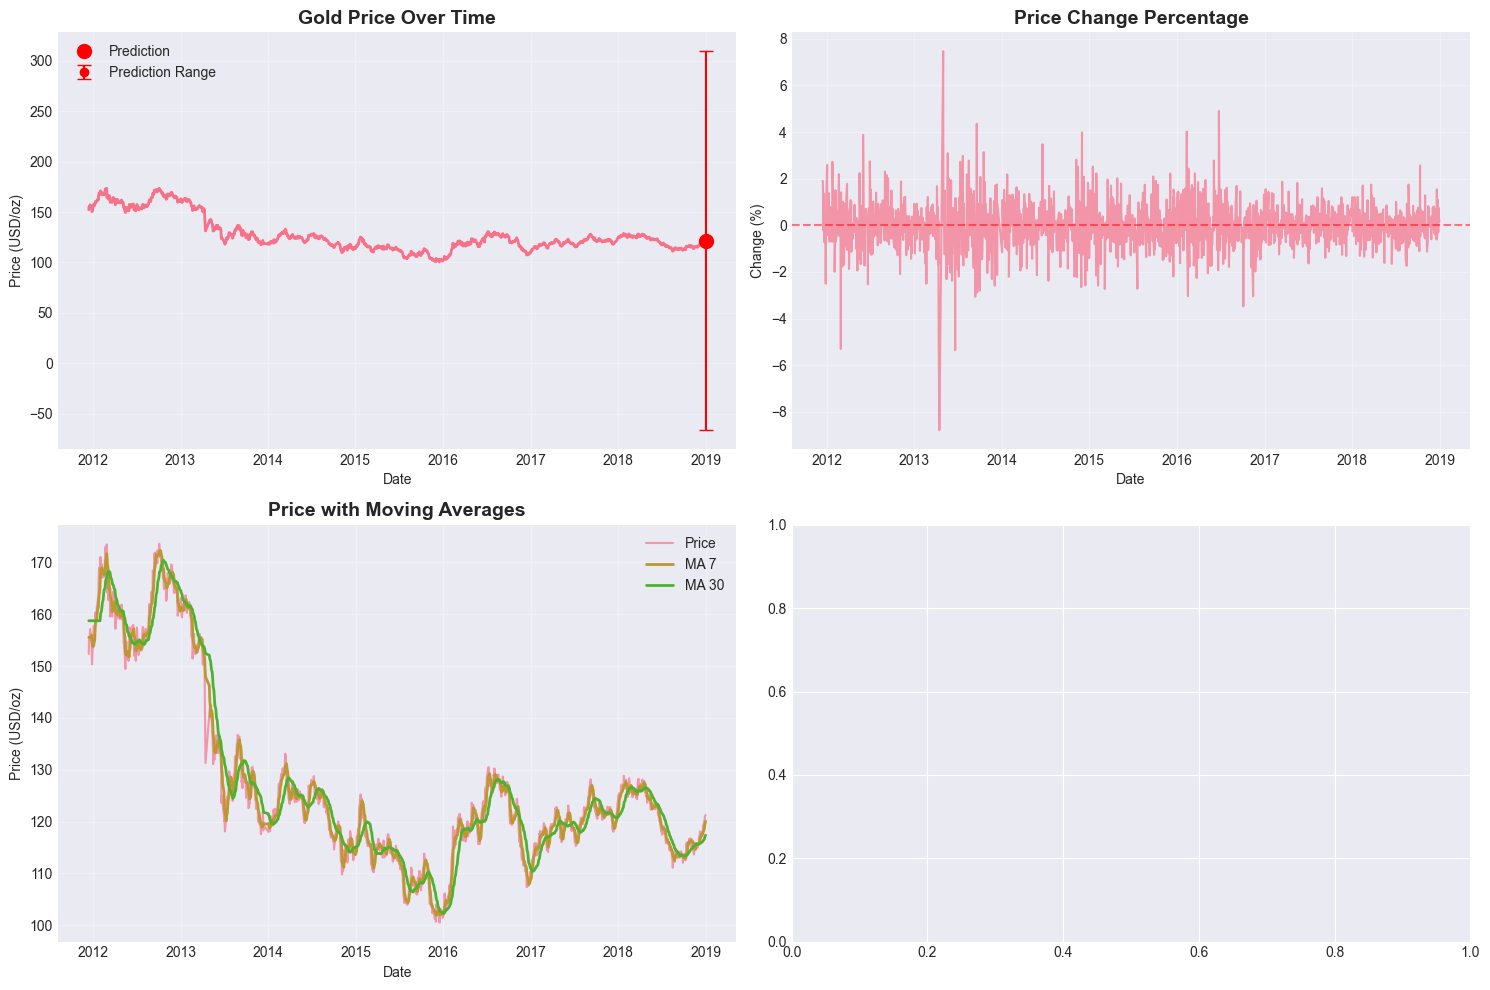

In [24]:
# Visualize gold price trends
if 'df_processed' in locals() and price_col and date_col:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Price over time
    axes[0, 0].plot(df_processed[date_col], df_processed[price_col], linewidth=2)
    axes[0, 0].set_title('Gold Price Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price (USD/oz)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add prediction point if available
    if 'predictions' in locals() and 'predicted_price' in predictions:
        last_date = df_processed[date_col].iloc[-1]
        next_date = last_date + pd.Timedelta(days=1)
        axes[0, 0].plot(next_date, predictions['predicted_price'], 'ro', markersize=10, label='Prediction')
        axes[0, 0].errorbar(next_date, predictions['predicted_price'], 
                           yerr=[[predictions['predicted_price'] - predictions['price_range_low']],
                                 [predictions['price_range_high'] - predictions['predicted_price']]],
                           fmt='ro', capsize=5, label='Prediction Range')
        axes[0, 0].legend()
    
    # Plot 2: Price changes
    if 'price_change_pct' in df_processed.columns:
        axes[0, 1].plot(df_processed[date_col], df_processed['price_change_pct'], alpha=0.7)
        axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('Price Change Percentage', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('Change (%)')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Moving averages
    if 'ma_7' in df_processed.columns and 'ma_30' in df_processed.columns:
        axes[1, 0].plot(df_processed[date_col], df_processed[price_col], label='Price', alpha=0.7)
        axes[1, 0].plot(df_processed[date_col], df_processed['ma_7'], label='MA 7', linewidth=2)
        axes[1, 0].plot(df_processed[date_col], df_processed['ma_30'], label='MA 30', linewidth=2)
        axes[1, 0].set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Price (USD/oz)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: News sentiment and price indicators
    if 'news_df' in locals() and not news_df.empty and 'sentiment_stats' in locals():
        # Create combined sentiment visualization
        rise_fall_counts = [
            sentiment_stats.get('rise_indicator_count', 0),
            sentiment_stats.get('fall_indicator_count', 0)
        ]
        labels = ['Rise Indicators', 'Fall Indicators']
        colors = ['green', 'red']
        axes[1, 1].bar(labels, rise_fall_counts, color=colors, alpha=0.7)
        axes[1, 1].set_title('News Price Direction Indicators', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Number of News Items')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add combined sentiment score as text
        combined_sent = sentiment_stats.get('avg_combined_sentiment', 0.0)
        if combined_sent > 0.1:
            signal_text = 'RISE Signal'
            signal_color = 'green'
        elif combined_sent < -0.1:
            signal_text = 'FALL Signal'
            signal_color = 'red'
        else:
            signal_text = 'NEUTRAL'
            signal_color = 'gray'
        
        max_count = max(rise_fall_counts) if rise_fall_counts and max(rise_fall_counts) > 0 else 1
        axes[1, 1].text(0.5, max_count * 0.9, f'Signal: {signal_text}', 
                       ha='center', fontsize=12, fontweight='bold', color=signal_color,
                       transform=axes[1, 1].transData)
    
    plt.tight_layout()
    plt.show()
else:
    print("Data not available for visualization")


## 12. Notes and Next Steps

### API Configuration:
- **Alpha Vantage**: Used for real-time gold price data (API key configured in Configuration section)
- **Google RSS**: Used for news sentiment analysis with gold-specific price indicators

### Model Improvements:
- Use more sophisticated models (LSTM, XGBoost, etc.)
- Implement prediction intervals for better uncertainty estimation
- Add more features (economic indicators, other commodity prices)
- Implement time-series cross-validation
- Add ensemble methods
- Enhance keyword detection for news analysis

### Data Updates:
- Set up scheduled runs to fetch latest news and API prices
- Implement real-time monitoring
- Create alerts for significant price movements
- Expand keyword vocabulary for better price direction prediction
